## Load Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import utils
import dotenv

import numpy as np
from sklearn.metrics import mean_squared_error
from nixtla import NixtlaClient 
from nixtlats import TimeGPT
from nixtlats.date_features import CountryHolidays
from dotenv import load_dotenv
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import pvlib
from pvlib.location import Location

from dotenv import load_dotenv

load_dotenv()

True

## Assess if our TimeGPT token is valid

In [3]:
# nixtla_client = NixtlaClient()
# nixtla_client.validate_api_key()

## Data

In [4]:
# Read the dataset and convert the 'DATE_LOCAL' column to datetime:
data = pd.read_csv('data/trans_sample_en.csv')
data['DATE_LOCAL'] = pd.to_datetime(data['DATE_LOCAL'], format="%d.%m.%Y %H:%M:%S")
data = data[['MERCHANT_NAME', 'INST_CODE','INST_CODE_2', 'R_ACTIV', 'R_ACTIV.1', 'IS_PETROL', 'COUNT', 'PRICE',   
           'LOYALTY_ARTICLE_NAME', 'PROMOTION_ID', 'TOVAR', 'TOVAR_2', 'TOVAR_3',  'DATE_LOCAL', 'YEAR', 'MONTH']]
data = data.sort_values(by=['MERCHANT_NAME', 'INST_CODE', 'INST_CODE_2'])
data.head(5)

,MERCHANT_NAME,INST_CODE,INST_CODE_2,R_ACTIV,R_ACTIV.1,IS_PETROL,COUNT,PRICE,LOYALTY_ARTICLE_NAME,PROMOTION_ID,TOVAR,TOVAR_2,TOVAR_3,DATE_LOCAL,YEAR,MONTH
55,0,7,7,34,34,1,0.0000,59.43847,АИ-92-К5,262040,AI,AI-92,0,2021-07-06 21:16:56,2021,7
56,0,7,7,34,34,1,31.3899,59.43847,АИ-92-К5,0,AI,AI-92,0,2021-07-06 21:16:56,2021,7
283,0,7,7,34,34,1,36.4900,58.43872,АИ-92-К5,0,AI,AI-92,0,2023-01-20 04:07:39,2023,1
304,0,7,7,34,34,1,11.4100,58.43872,АИ-92-К5,0,AI,AI-92,0,2023-01-20 04:11:36,2023,1
308,0,7,7,34,34,0,1.0000,211.94700,Кофе Латте 400мл + сироп,0,ST,ST,0,2023-01-20 04:13:09,2023,1


In [5]:
# Creating new features:
data['WEEK'] = data['DATE_LOCAL'].dt.isocalendar().week # Number of the week
data['ds'] = data['DATE_LOCAL'].dt.to_period('W').apply(lambda r: r.start_time) # The beginning of the week
categorical_columns = ['TOVAR', 'TOVAR_2', 'TOVAR_3', 'IS_PETROL']
df = pd.get_dummies(data, columns=categorical_columns, prefix=categorical_columns)

In [6]:
# Aggregation of data by week:
df = df.groupby(['MERCHANT_NAME','INST_CODE', 'INST_CODE_2', 'ds' ,'WEEK']).agg({
    'COUNT': 'sum', 
    'PRICE': 'sum',  
    'R_ACTIV': 'mean',
    'LOYALTY_ARTICLE_NAME': 'nunique',
    'PROMOTION_ID': 'sum',
    'TOVAR_AI': 'sum',
    'TOVAR_DT': 'sum',
    'TOVAR_ST': 'sum',
    'TOVAR_2_AI-92': 'sum',
    'TOVAR_2_AI-95': 'sum',
    'TOVAR_2_DT': 'sum',
    'TOVAR_2_ST': 'sum',
    'TOVAR_3_0': 'sum',
    'TOVAR_3_1': 'sum',
    'IS_PETROL_0': 'sum',
    'IS_PETROL_1': 'sum'
}).reset_index()
df.head(5)

,MERCHANT_NAME,INST_CODE,INST_CODE_2,ds,WEEK,COUNT,PRICE,R_ACTIV,LOYALTY_ARTICLE_NAME,PROMOTION_ID,...,TOVAR_DT,TOVAR_ST,TOVAR_2_AI-92,TOVAR_2_AI-95,TOVAR_2_DT,TOVAR_2_ST,TOVAR_3_0,TOVAR_3_1,IS_PETROL_0,IS_PETROL_1
0,0,7,7,2020-12-28,53,5863.0015,26828.95775,36.778068,35,19731593,...,15,39,223,106,15,39,383,0,39,344
1,0,7,7,2021-01-04,1,17915.7503,77798.54550,37.955211,85,60226963,...,49,114,690,308,49,114,1161,0,114,1047
2,0,7,7,2021-01-11,2,18600.6374,73246.41715,37.356312,67,58730649,...,56,88,724,249,56,88,1117,0,88,1029
3,0,7,7,2021-01-18,3,17078.4223,71352.62405,37.013436,67,51041254,...,43,96,670,233,43,96,1042,0,96,946
4,0,7,7,2021-01-25,4,15066.5430,67117.81635,37.122234,65,46362410,...,42,88,615,204,42,88,949,0,88,861


In [7]:
# Add Temperature*:
df.set_index('ds', inplace=True)
region = {"latitude": 55.7558, "longitude": 37.6173}
location = Location(region['latitude'], region['longitude'], 'Europe/Moscow', 0, 'Moscow')
solar_position = location.get_solarposition(df.index)
df['TEMPERATURE'] = 90 - solar_position['apparent_elevation']
df.reset_index(inplace=True)

In [8]:
# Creating ID, deleting series and weeks with insufficient data:
df["ID"] = df['MERCHANT_NAME'].astype(str)+'-'+df['INST_CODE'].astype(str)
df = df[df['ID'] != '1-3-3']
df = df[df['ds'] != '2020-12-21']
df = df[df['ds'] != '2020-12-28']
df = df[df['ds'] != '2023-10-30']
df.head(5)

,ds,MERCHANT_NAME,INST_CODE,INST_CODE_2,WEEK,COUNT,PRICE,R_ACTIV,LOYALTY_ARTICLE_NAME,PROMOTION_ID,...,TOVAR_2_AI-92,TOVAR_2_AI-95,TOVAR_2_DT,TOVAR_2_ST,TOVAR_3_0,TOVAR_3_1,IS_PETROL_0,IS_PETROL_1,TEMPERATURE,ID
1,2021-01-04,0,7,7,1,17915.7503,77798.54550,37.955211,85,60226963,...,690,308,49,114,1161,0,114,1047,137.475947,0-7
2,2021-01-11,0,7,7,2,18600.6374,73246.41715,37.356312,67,58730649,...,724,249,56,88,1117,0,88,1029,137.013092,0-7
3,2021-01-18,0,7,7,3,17078.4223,71352.62405,37.013436,67,51041254,...,670,233,43,96,1042,0,96,946,136.179620,0-7
4,2021-01-25,0,7,7,4,15066.5430,67117.81635,37.122234,65,46362410,...,615,204,42,88,949,0,88,861,134.983992,0-7
5,2021-02-01,0,7,7,5,15655.3032,54993.51485,37.770777,59,0,...,487,146,33,80,746,0,80,666,133.449360,0-7


In [9]:
# Filling in the gaps:
min_date = df['ds'].min()
max_date = df['ds'].max()

full_date_range = pd.date_range(start=min_date, end=max_date, freq='W-MON')
df_filled_list = []

for id_val, group in df.groupby('ID'):
    group = group.set_index('ds').reindex(full_date_range).rename_axis('ds').reset_index()
    group['ID'] = id_val
    df_filled_list.append(group)

df_filled = pd.concat(df_filled_list)

def fillna_mode(series):
    mode = series.mode()
    if not mode.empty:
        return series.fillna(mode[0])
    return series

df_filled['WEEK'] = df_filled.groupby('ID')['WEEK'].transform(fillna_mode)

def fillna_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        if col not in 'WEEK':
            df[col] = df[col].fillna(df[col].mean())
    return df

df_filled = df_filled.groupby('ID').apply(fillna_mean).reset_index(drop=True)
df_filled.head(5)

,ds,MERCHANT_NAME,INST_CODE,INST_CODE_2,WEEK,COUNT,PRICE,R_ACTIV,LOYALTY_ARTICLE_NAME,PROMOTION_ID,...,TOVAR_2_AI-92,TOVAR_2_AI-95,TOVAR_2_DT,TOVAR_2_ST,TOVAR_3_0,TOVAR_3_1,IS_PETROL_0,IS_PETROL_1,TEMPERATURE,ID
0,2021-01-04,0.0,7.0,7.0,1,17915.7503,77798.54550,37.955211,85.0,60226963.0,...,690.0,308.0,49.0,114.0,1161.0,0.0,114.0,1047.0,137.475947,0-7
1,2021-01-11,0.0,7.0,7.0,2,18600.6374,73246.41715,37.356312,67.0,58730649.0,...,724.0,249.0,56.0,88.0,1117.0,0.0,88.0,1029.0,137.013092,0-7
2,2021-01-18,0.0,7.0,7.0,3,17078.4223,71352.62405,37.013436,67.0,51041254.0,...,670.0,233.0,43.0,96.0,1042.0,0.0,96.0,946.0,136.179620,0-7
3,2021-01-25,0.0,7.0,7.0,4,15066.5430,67117.81635,37.122234,65.0,46362410.0,...,615.0,204.0,42.0,88.0,949.0,0.0,88.0,861.0,134.983992,0-7
4,2021-02-01,0.0,7.0,7.0,5,15655.3032,54993.51485,37.770777,59.0,0.0,...,487.0,146.0,33.0,80.0,746.0,0.0,80.0,666.0,133.449360,0-7


In [10]:
# Rename
df_filled = df_filled.set_index(['ID', 'ds'], drop=False)       
df_filled.rename(columns={'COUNT': 'y'}, inplace=True) 
df_filled.rename(columns={'ID': 'unique_id'}, inplace=True)

df_filled.reset_index(drop=True, inplace=True)
df_filled.head(5)

,ds,MERCHANT_NAME,INST_CODE,INST_CODE_2,WEEK,y,PRICE,R_ACTIV,LOYALTY_ARTICLE_NAME,PROMOTION_ID,...,TOVAR_2_AI-92,TOVAR_2_AI-95,TOVAR_2_DT,TOVAR_2_ST,TOVAR_3_0,TOVAR_3_1,IS_PETROL_0,IS_PETROL_1,TEMPERATURE,unique_id
0,2021-01-04,0.0,7.0,7.0,1,17915.7503,77798.54550,37.955211,85.0,60226963.0,...,690.0,308.0,49.0,114.0,1161.0,0.0,114.0,1047.0,137.475947,0-7
1,2021-01-11,0.0,7.0,7.0,2,18600.6374,73246.41715,37.356312,67.0,58730649.0,...,724.0,249.0,56.0,88.0,1117.0,0.0,88.0,1029.0,137.013092,0-7
2,2021-01-18,0.0,7.0,7.0,3,17078.4223,71352.62405,37.013436,67.0,51041254.0,...,670.0,233.0,43.0,96.0,1042.0,0.0,96.0,946.0,136.179620,0-7
3,2021-01-25,0.0,7.0,7.0,4,15066.5430,67117.81635,37.122234,65.0,46362410.0,...,615.0,204.0,42.0,88.0,949.0,0.0,88.0,861.0,134.983992,0-7
4,2021-02-01,0.0,7.0,7.0,5,15655.3032,54993.51485,37.770777,59.0,0.0,...,487.0,146.0,33.0,80.0,746.0,0.0,80.0,666.0,133.449360,0-7


## Plot Actuals

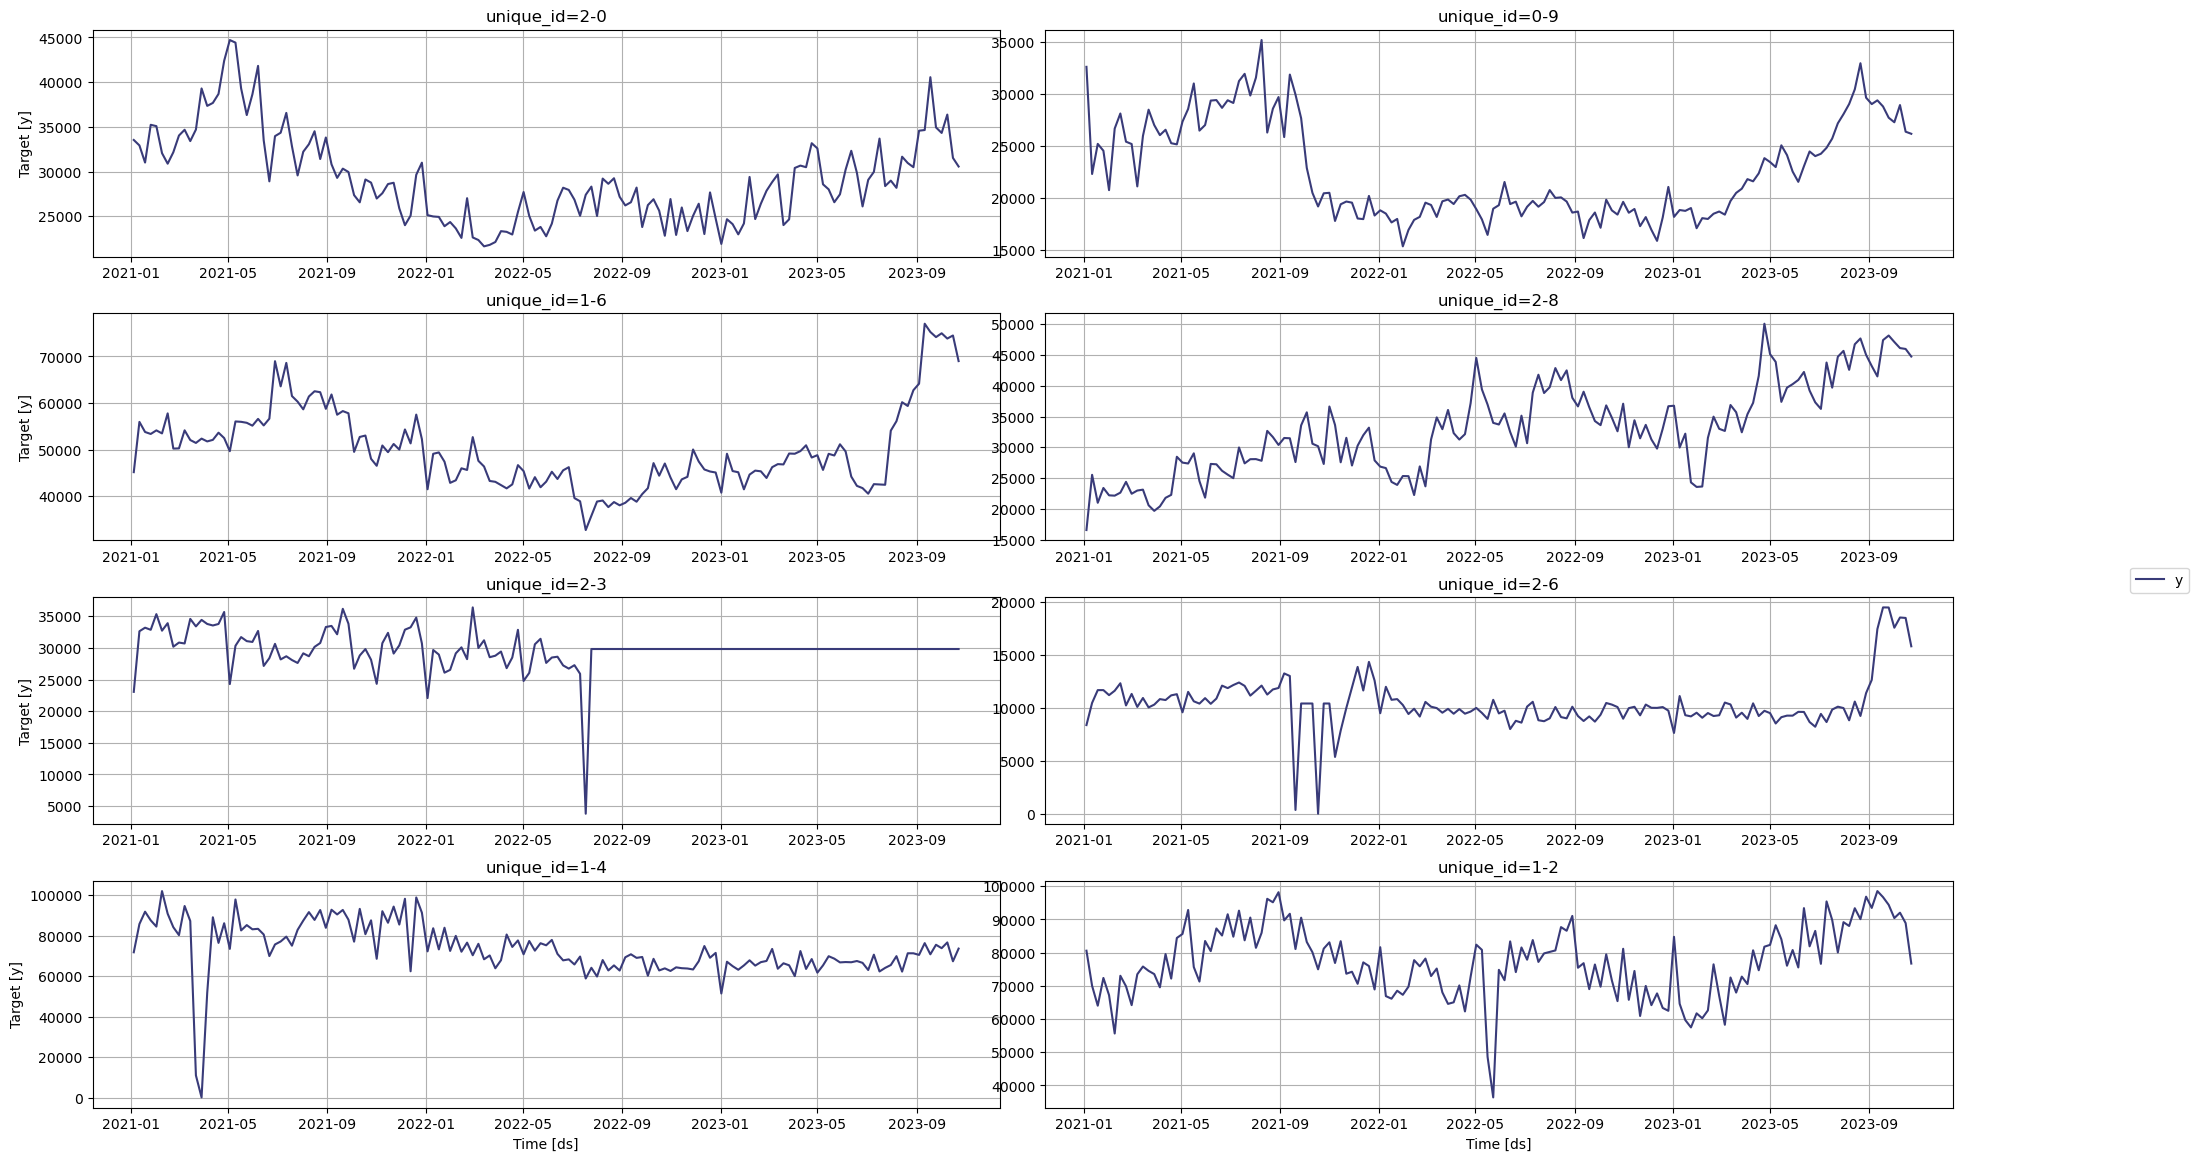

In [11]:
nixtla_client.plot(df_filled)

## Split data between train and test

In [12]:
forecast_df = df_filled[df_filled['ds'] < "2023-06-26"]
holdout_df = df_filled[(df_filled['ds'] >= "2023-06-26") & (df_filled['ds'] <= "2023-10-23")]
future_ex_vars_df = holdout_df.drop(columns=['y', 'INST_CODE_2'])
df1 = forecast_df.drop(columns=['INST_CODE_2'])
print(f"Weeks for training: {len(forecast_df['ds'].unique())} from {min(forecast_df['ds']).date()} to {max(forecast_df['ds']).date()}")
print(f"Weeks for testing: {len(holdout_df['ds'].unique())} from {min(holdout_df['ds']).date()} to {max(holdout_df['ds']).date()}")

Weeks for training: 129 from 2021-01-04 to 2023-06-19
Weeks for testing: 18 from 2023-06-26 to 2023-10-23


## Forecast

In [13]:
%%time
timegpt_fcst_ex_vars_df = nixtla_client.forecast(
    df=df1, 
    X_df=future_ex_vars_df, 
    h=18, 
    level=[80, 90], 
    freq="W", 
    add_history=True
    )
timegpt_fcst_ex_vars_df.to_csv('forecasted_nixtla.csv', index=False)
timegpt_fcst_ex_vars_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: W-MON
INFO:nixtla.nixtla_client:Using the following exogenous variables: MERCHANT_NAME, INST_CODE, WEEK, PRICE, R_ACTIV, LOYALTY_ARTICLE_NAME, PROMOTION_ID, TOVAR_AI, TOVAR_DT, TOVAR_ST, TOVAR_2_AI-92, TOVAR_2_AI-95, TOVAR_2_DT, TOVAR_2_ST, TOVAR_3_0, TOVAR_3_1, IS_PETROL_0, IS_PETROL_1, TEMPERATURE
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...


CPU times: total: 875 ms
Wall time: 7.95 s


,unique_id,ds,TimeGPT,TimeGPT-lo-80,TimeGPT-lo-90,TimeGPT-hi-80,TimeGPT-hi-90
0,0-7,2022-02-07,12313.589155,11549.199118,11332.505164,13077.979193,13294.673147
1,0-7,2022-02-14,14452.009144,13687.619107,13470.925153,15216.399182,15433.093136
2,0-7,2022-02-21,13497.436985,12733.046947,12516.352993,14261.827022,14478.520977
3,0-7,2022-02-28,14032.348802,13267.958765,13051.264811,14796.738840,15013.432794
4,0-7,2022-03-07,14241.576658,13477.186621,13260.492667,15005.966696,15222.660650


## Plot Actuals and Forecast

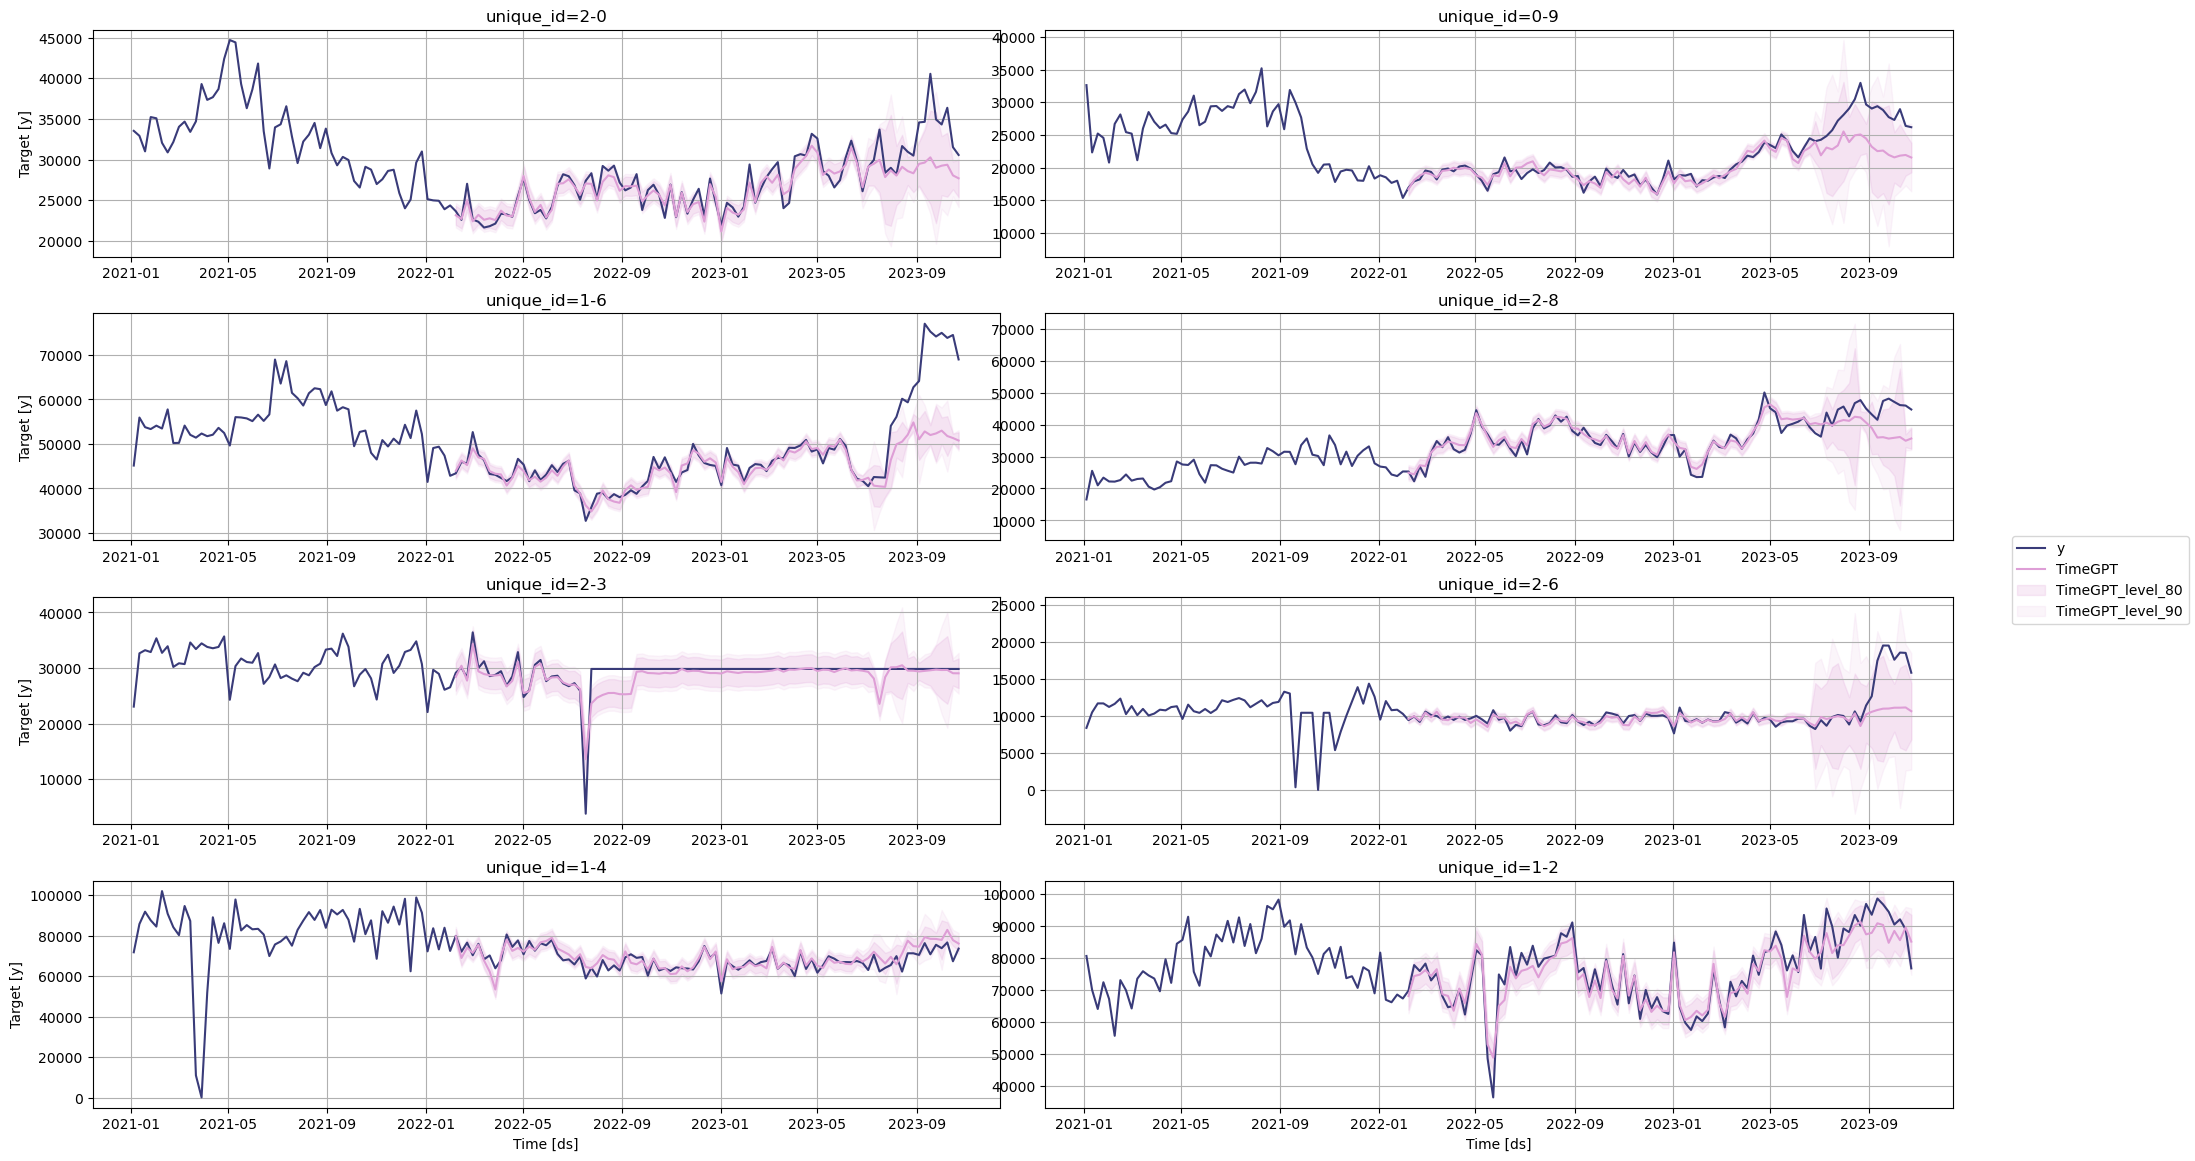

In [14]:
nixtla_client.plot(
    df_filled[['unique_id', 'ds', 'y']], 
    timegpt_fcst_ex_vars_df, 
    max_insample_length=365, 
    level=[80, 90], 
)

## Plot Importance of Exogenous Features

Text(0.5, 1.0, 'Top 10 weights')

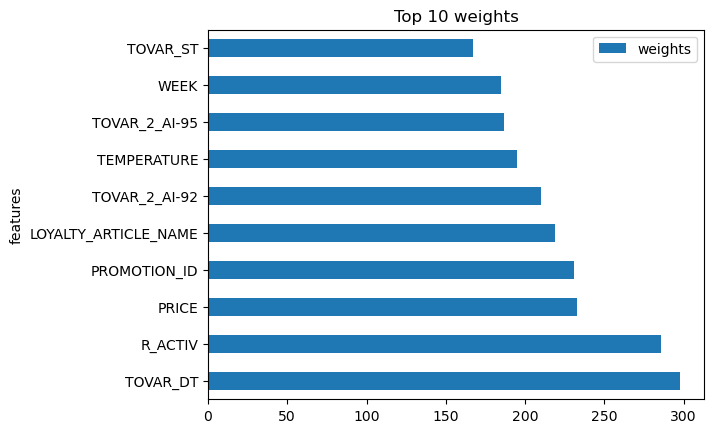

In [15]:
top_features = nixtla_client.weights_x.sort_values(by='weights', ascending=False).head(10)
top_features.plot.barh(x='features', y='weights').set_title('Top 10 weights')

### Model Evaluation

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


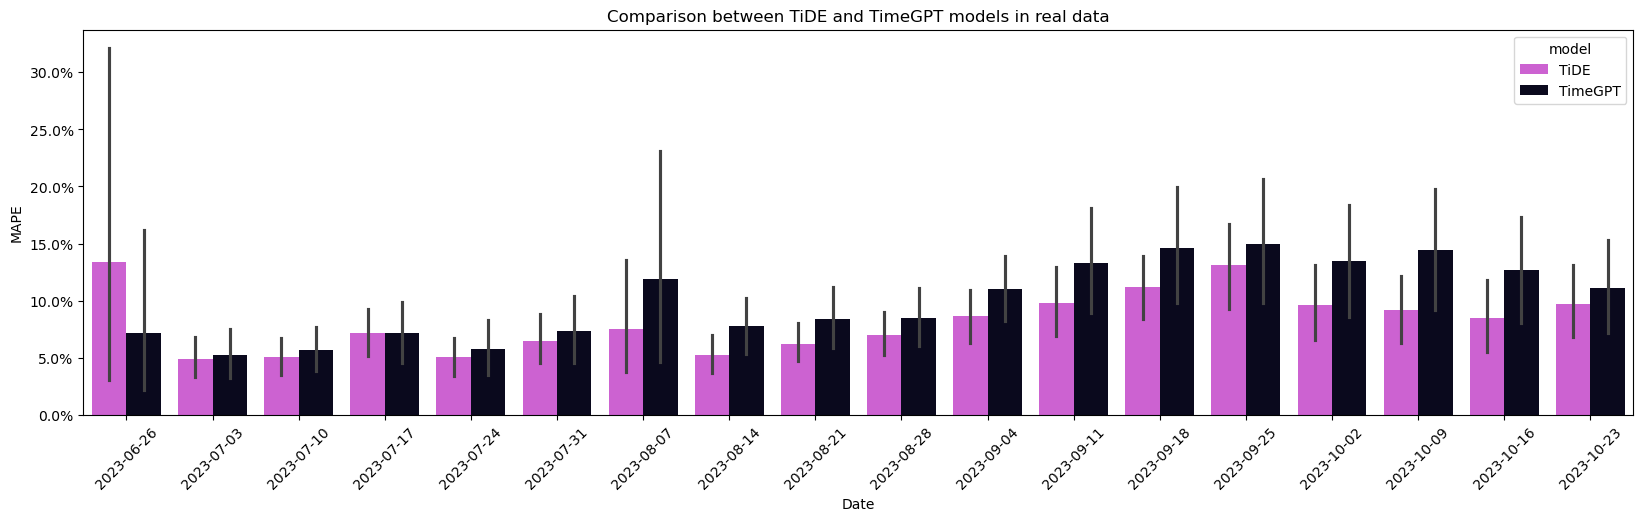

In [16]:
# load the forecast from TiDE and TimeGPT
test_ = pd.read_csv('test.csv').dropna()
tide_model_df = pd.read_csv('tide.csv')
timegpt_fcst_ex_vars_df = pd.read_csv('forecasted_nixtla.csv')

test_.rename(columns={'Weekly_Sales': 'target'}, inplace=True)
timegpt_fcst_ex_vars_df.rename(columns={'ds': 'Date'}, inplace=True)

# merge data frames with TiDE forecast and actuals
model_eval_df = pd.merge(test_[['unique_id', 'Date', 'target']], tide_model_df[['unique_id', 'Date', 'forecast']], on=['unique_id', 'Date'], how='inner')
model_eval_df = pd.merge(model_eval_df, timegpt_fcst_ex_vars_df[['unique_id', 'Date', 'TimeGPT']], on=['unique_id', 'Date'], how='inner')
utils.plot_model_comparison(model_eval_df)